# Driver Performance Prediction
## Extract Data

In [196]:
# pip install pandas
# pip install matplotlib
# pip install sqlite3
# pip install kaggle
# move kaggle.json file into ~/.kaggle (mac) or C:\Users<Windows-username>.kaggle\kaggle.json (windows)

import kaggle
import pandas as pd
import numpy as np
import matplotlib as plt
import sqlite3 as db

dataset = "rohanrao/formula-1-world-championship-1950-2020"

kaggle.api.dataset_download_files(dataset, path='./', unzip=True)

print(f"Dataset {dataset} downloaded successfully!")

Dataset URL: https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020
Dataset rohanrao/formula-1-world-championship-1950-2020 downloaded successfully!


In [197]:
results_df = pd.read_csv('results.csv')
qualifying_df = pd.read_csv('qualifying.csv')
lap_times_df = pd.read_csv('lap_times.csv')
pit_stops_df = pd.read_csv('pit_stops.csv')
driver_standings_df = pd.read_csv('driver_standings.csv')
driver_df = pd.read_csv('drivers.csv')
races_df = pd.read_csv('races.csv')
constructors_df = pd.read_csv('constructors.csv')
status_df = pd.read_csv('status.csv')

## Transform Data
Changing data types, dropping and renaming columns

In [198]:

results_df.drop(['number', 'positionText', 'time', 'rank', 'fastestLap', 'fastestLapTime', 'fastestLapSpeed', 'laps', 'points', 'positionOrder', 'grid'], axis=1, inplace=True)

results_df.rename(columns={'position': 'final_position'}, inplace=True)

results_df['final_position'] = results_df['final_position'].replace('\\N', np.nan)
results_df.final_position = pd.to_numeric(results_df.final_position, errors='coerce')
results_df.milliseconds = pd.to_numeric(results_df.milliseconds, errors='coerce')
print(results_df.dtypes)
display(results_df)

resultId            int64
raceId              int64
driverId            int64
constructorId       int64
final_position    float64
milliseconds      float64
statusId            int64
dtype: object


,resultId,raceId,driverId,constructorId,final_position,milliseconds,statusId
0,1,18,1,1,1.0,5690616.0,1
1,2,18,2,2,2.0,5696094.0,1
2,3,18,3,3,3.0,5698779.0,1
3,4,18,4,4,4.0,5707797.0,1
4,5,18,5,1,5.0,5708630.0,1
...,...,...,...,...,...,...,...
26514,26520,1132,839,214,16.0,NaN,12
26515,26521,1132,815,9,17.0,NaN,12
26516,26522,1132,855,15,18.0,NaN,12
26517,26523,1132,847,131,NaN,NaN,34


In [199]:
qualifying_df.drop(['number', 'q1', 'q2', 'q3', 'qualifyId'], axis=1, inplace=True)
qualifying_df.rename(columns={'position': 'qualifying_position'}, inplace=True)

print(qualifying_df.dtypes)
display(qualifying_df)

raceId                 int64
driverId               int64
constructorId          int64
qualifying_position    int64
dtype: object


,raceId,driverId,constructorId,qualifying_position
0,18,1,1,1
1,18,9,2,2
2,18,5,1,3
3,18,13,6,4
4,18,2,2,5
...,...,...,...,...
10249,1132,822,15,16
10250,1132,825,210,17
10251,1132,839,214,18
10252,1132,815,9,19


In [200]:
lap_times_df.drop(['time', 'lap', 'position'], axis=1, inplace=True)
lap_times_df.rename(columns={'milliseconds': 'lap_time_milliseconds'}, inplace=True)

print(lap_times_df.dtypes)
display(lap_times_df)

raceId                   int64
driverId                 int64
lap_time_milliseconds    int64
dtype: object


,raceId,driverId,lap_time_milliseconds
0,841,20,98109
1,841,20,93006
2,841,20,92713
3,841,20,92803
4,841,20,92342
...,...,...,...
575024,1131,858,70742
575025,1131,858,70855
575026,1131,858,72454
575027,1131,858,73607


In [201]:
pit_stops_df.drop(['milliseconds', 'time', 'lap'], axis=1, inplace=True)
pit_stops_df.rename(columns={'duration': 'stop_duration', 'stop':'pit_stop'}, inplace=True)

pit_stops_df.stop_duration = pd.to_numeric(pit_stops_df.stop_duration, errors='coerce')
print(pit_stops_df.dtypes)
display(pit_stops_df)

raceId             int64
driverId           int64
pit_stop           int64
stop_duration    float64
dtype: object


,raceId,driverId,pit_stop,stop_duration
0,841,153,1,26.898
1,841,30,1,25.021
2,841,17,1,23.426
3,841,4,1,23.251
4,841,13,1,23.842
...,...,...,...,...
10985,1132,807,2,30.265
10986,1132,840,2,29.469
10987,1132,839,4,29.086
10988,1132,815,4,28.871


In [202]:
driver_standings_df.drop(['position','positionText', 'wins', 'driverStandingsId'], axis=1, inplace=True)
driver_standings_df.rename(columns={'points': 'driver_points'}, inplace=True)

print(driver_standings_df.dtypes)
display(driver_standings_df)

raceId             int64
driverId           int64
driver_points    float64
dtype: object


,raceId,driverId,driver_points
0,18,1,10.0
1,18,2,8.0
2,18,3,6.0
3,18,4,5.0
4,18,5,4.0
...,...,...,...
34590,1132,839,3.0
34591,1132,842,6.0
34592,1132,822,0.0
34593,1132,858,0.0


In [203]:
driver_df['driver_name'] = driver_df['forename'] + ' ' + driver_df['surname']
driver_df.drop(['driverRef','number', 'code', 'dob', 'nationality', 'url', 'forename', 'surname'], axis=1, inplace=True)
driver_df.head()

,driverId,driver_name
0,1,Lewis Hamilton
1,2,Nick Heidfeld
2,3,Nico Rosberg
3,4,Fernando Alonso
4,5,Heikki Kovalainen


In [204]:
races_df.drop(['date','time', 'round','url', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time'], axis=1, inplace=True)
races_df.rename(columns={'name': 'circuit_name'}, inplace=True)

print(races_df.dtypes)
display(races_df)

raceId           int64
year             int64
circuitId        int64
circuit_name    object
dtype: object


,raceId,year,circuitId,circuit_name
0,1,2009,1,Australian Grand Prix
1,2,2009,2,Malaysian Grand Prix
2,3,2009,17,Chinese Grand Prix
3,4,2009,3,Bahrain Grand Prix
4,5,2009,4,Spanish Grand Prix
...,...,...,...,...
1120,1140,2024,32,Mexico City Grand Prix
1121,1141,2024,18,São Paulo Grand Prix
1122,1142,2024,80,Las Vegas Grand Prix
1123,1143,2024,78,Qatar Grand Prix


In [205]:
constructors_df.drop(['url', 'nationality', 'constructorRef'], axis=1, inplace=True)
constructors_df.rename(columns={'name': 'constructor_name'}, inplace=True)

print(constructors_df.dtypes)
display(constructors_df)

constructorId        int64
constructor_name    object
dtype: object


,constructorId,constructor_name
0,1,McLaren
1,2,BMW Sauber
2,3,Williams
3,4,Renault
4,5,Toro Rosso
...,...,...
207,210,Haas F1 Team
208,211,Racing Point
209,213,AlphaTauri
210,214,Alpine F1 Team


In [206]:
print(status_df.dtypes)
display(status_df)

statusId     int64
status      object
dtype: object


,statusId,status
0,1,Finished
1,2,Disqualified
2,3,Accident
3,4,Collision
4,5,Engine
...,...,...
134,137,Damage
135,138,Debris
136,139,Illness
137,140,Undertray


In [207]:
races_years = races_df['year'].unique()

lap_times_years = pd.merge(lap_times_df, races_df, on='raceId')['year'].unique()
pit_stops_years = pd.merge(pit_stops_df, races_df, on='raceId')['year'].unique()
qualifying_years = pd.merge(qualifying_df, races_df, on='raceId')['year'].unique()

races_years.sort(), lap_times_years.sort(), pit_stops_years.sort(), qualifying_years.sort()

(races_years, lap_times_years, pit_stops_years, qualifying_years)

(array([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
        1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
        1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
        1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
        1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
        2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
        2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]),
 array([1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
        2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
        2018, 2019, 2020, 2021, 2022, 2023, 2024]),
 array([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
        2022, 2023, 2024]),
 array([1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
        2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
        2016, 2017, 2018, 2019, 2020, 2021

## Merging data

In [208]:
# merge datasets together


merge1_df = pd.merge(results_df, races_df, on='raceId', how='inner')
merge1_df = merge1_df.drop_duplicates(subset=['raceId', 'driverId'])

merge2_df = pd.merge(merge1_df, constructors_df, on='constructorId', how='inner')
merge2_df = merge2_df.drop_duplicates(subset=['raceId', 'driverId'])

merge3_df = pd.merge(merge2_df, driver_standings_df, on=['driverId', 'raceId'], how='inner')
merge3_df = merge3_df.drop_duplicates(subset=['raceId', 'driverId'])

merge4_df = pd.merge(merge3_df, driver_df, on=['driverId'])

merge5_df = pd.merge(merge4_df, lap_times_df, on=['driverId', 'raceId'], how='inner')
merge5_df = merge5_df.drop_duplicates(subset=['raceId', 'driverId'])

merge6_df = pd.merge(merge5_df, pit_stops_df, on=['driverId', 'raceId'], how='inner')
merge6_df = merge6_df.drop_duplicates(subset=['raceId', 'driverId'])

merge7_df = pd.merge(merge6_df, qualifying_df, on=['driverId', 'raceId'], how='inner')
merge7_df = merge7_df.drop_duplicates(subset=['raceId', 'driverId'])

combined_df = pd.merge(merge7_df, status_df, on='statusId', how='inner')
combined_df = combined_df.drop_duplicates(subset=['raceId', 'driverId'])

duplicates_check = combined_df.duplicated(subset=['raceId', 'driverId']).any()
print(duplicates_check)

display(combined_df)


False


,resultId,raceId,driverId,constructorId_x,final_position,milliseconds,statusId,year,circuitId,circuit_name,constructor_name,driver_points,driver_name,lap_time_milliseconds,pit_stop,stop_duration,constructorId_y,qualifying_position,status
0,20779,841,20,9,1.0,5370259.0,1,2011,1,Australian Grand Prix,Red Bull,25.0,Sebastian Vettel,98109,1,22.603,9,1,Finished
1,20780,841,1,1,2.0,5392556.0,1,2011,1,Australian Grand Prix,McLaren,18.0,Lewis Hamilton,100573,1,23.227,1,2,Finished
2,20781,841,808,4,3.0,5400819.0,1,2011,1,Australian Grand Prix,Renault,15.0,Vitaly Petrov,102835,1,24.535,4,6,Finished
3,20782,841,4,6,4.0,5402031.0,1,2011,1,Australian Grand Prix,Ferrari,12.0,Fernando Alonso,106144,1,23.251,6,5,Finished
4,20783,841,17,9,5.0,5408430.0,1,2011,1,Australian Grand Prix,Red Bull,10.0,Mark Webber,101467,1,23.426,9,3,Finished
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5300,26500,1131,822,15,16.0,NaN,11,2024,70,Austrian Grand Prix,Sauber,0.0,Valtteri Bottas,80918,1,21.918,15,18,+1 Lap
5301,26501,1131,855,15,17.0,NaN,11,2024,70,Austrian Grand Prix,Sauber,0.0,Guanyu Zhou,84058,1,23.198,15,20,+1 Lap
5302,26502,1131,4,117,18.0,NaN,11,2024,70,Austrian Grand Prix,Aston Martin,41.0,Fernando Alonso,79908,1,21.483,117,15,+1 Lap
5303,26503,1131,858,3,19.0,NaN,12,2024,70,Austrian Grand Prix,Williams,0.0,Logan Sargeant,84605,1,31.722,3,19,+2 Laps


# Filter and drop nulls
Only show drivers who have finished a race

In [209]:
combined_df.drop(['constructorId_y'], axis=1, inplace=True)
combined_df.rename(columns={'constructorId_x': 'constructorId'}, inplace=True)

df = combined_df[combined_df['status'] == 'Finished']

df = df.dropna()
df.isnull().sum()
display(df)

#df.to_csv('file1.csv')

,resultId,raceId,driverId,constructorId,final_position,milliseconds,statusId,year,circuitId,circuit_name,constructor_name,driver_points,driver_name,lap_time_milliseconds,pit_stop,stop_duration,qualifying_position,status
0,20779,841,20,9,1.0,5370259.0,1,2011,1,Australian Grand Prix,Red Bull,25.0,Sebastian Vettel,98109,1,22.603,1,Finished
1,20780,841,1,1,2.0,5392556.0,1,2011,1,Australian Grand Prix,McLaren,18.0,Lewis Hamilton,100573,1,23.227,2,Finished
2,20781,841,808,4,3.0,5400819.0,1,2011,1,Australian Grand Prix,Renault,15.0,Vitaly Petrov,102835,1,24.535,6,Finished
3,20782,841,4,6,4.0,5402031.0,1,2011,1,Australian Grand Prix,Ferrari,12.0,Fernando Alonso,106144,1,23.251,5,Finished
4,20783,841,17,9,5.0,5408430.0,1,2011,1,Australian Grand Prix,Red Bull,10.0,Mark Webber,101467,1,23.426,3,Finished
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5292,26492,1131,825,210,8.0,5123153.0,1,2024,70,Austrian Grand Prix,Haas F1 Team,5.0,Kevin Magnussen,78826,1,21.518,12,Finished
5293,26493,1131,817,215,9.0,5123967.0,1,2024,70,Austrian Grand Prix,RB F1 Team,11.0,Daniel Ricciardo,79507,1,21.502,11,Finished
5294,26494,1131,842,214,10.0,5124564.0,1,2024,70,Austrian Grand Prix,Alpine F1 Team,6.0,Pierre Gasly,79109,1,21.431,13,Finished
5295,26495,1131,844,6,11.0,5129854.0,1,2024,70,Austrian Grand Prix,Ferrari,150.0,Charles Leclerc,82085,1,31.917,6,Finished


# Exploratory Data Analysis (EDA)

In [210]:
print(df.dtypes)
display(df.describe())

resultId                   int64
raceId                     int64
driverId                   int64
constructorId              int64
final_position           float64
milliseconds             float64
statusId                   int64
year                       int64
circuitId                  int64
circuit_name              object
constructor_name          object
driver_points            float64
driver_name               object
lap_time_milliseconds      int64
pit_stop                   int64
stop_duration            float64
qualifying_position        int64
status                    object
dtype: object


,resultId,raceId,driverId,constructorId,final_position,milliseconds,statusId,year,circuitId,driver_points,lap_time_milliseconds,pit_stop,stop_duration,qualifying_position
count,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000,2.787000e+03,2787.0,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000
mean,23720.951561,985.928597,506.953714,59.529602,6.582705,5.886109e+06,1.0,2017.405095,25.673125,78.324363,108775.733764,1.028346,24.288727,8.100108
std,1701.486134,88.340493,396.930266,77.414752,4.102845,1.029226e+06,0.0,4.089700,25.221027,85.844709,20062.317904,0.188279,3.911071,5.392660
min,20779.000000,841.000000,1.000000,1.000000,1.000000,4.421143e+06,1.0,2011.000000,1.000000,0.000000,68922.000000,1.000000,16.369000,1.000000
25%,22145.500000,900.500000,16.000000,6.000000,3.000000,5.339457e+06,1.0,2014.000000,7.000000,15.000000,95685.000000,1.000000,21.869000,4.000000
50%,23764.000000,988.000000,815.000000,9.000000,6.000000,5.687892e+06,1.0,2017.000000,15.000000,46.000000,105925.000000,1.000000,23.430000,7.000000
75%,25287.500000,1067.000000,832.000000,131.000000,9.000000,6.074536e+06,1.0,2021.000000,32.000000,116.000000,117644.500000,1.000000,25.397000,12.000000
max,26496.000000,1131.000000,860.000000,215.000000,19.000000,1.474314e+07,1.0,2024.000000,80.000000,575.000000,257359.000000,3.000000,56.710000,23.000000


#### Load into SQLite

In [211]:
conn = db.connect('database.db')
cursor = conn.cursor()

df.to_sql('formula_one', conn, if_exists='replace')

2787

## Data Overview
### How many unique drivers, constructors (teams) and circuits are represented in the dataset

In [212]:
unique_drivers = pd.read_sql_query('SELECT COUNT(DISTINCT driver_name) AS unique_drivers FROM formula_one', conn)
display(unique_drivers)

unique_constructors = pd.read_sql_query('SELECT COUNT(DISTINCT constructor_name) AS unique_constructors FROM formula_one', conn)
display(unique_constructors)

unique_circuits = pd.read_sql_query('SELECT COUNT(DISTINCT circuit_name) AS unique_circuits FROM formula_one', conn)
display(unique_circuits)

,unique_drivers
0,68


,unique_constructors
0,22


,unique_circuits
0,40


## Performance-based Analysis
### How does the qualifying position influence the final race position

,qualifying_position,avg_final_position
0,1,1.927039
1,2,2.939655
2,3,3.524664
3,4,4.117117
4,5,4.909091
5,6,5.583784
6,7,6.443182
7,8,7.448718
8,9,7.652778
9,10,7.962406


<Axes: xlabel='qualifying_position', ylabel='avg_final_position'>

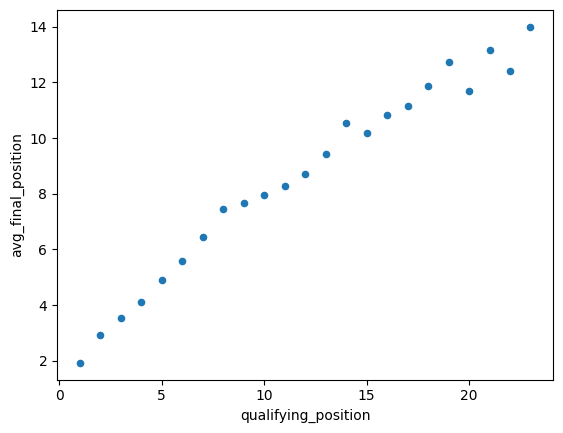

In [213]:
# 23 positions in qualifying
qualifying_influence = pd.read_sql_query('SELECT qualifying_position, AVG(final_position) AS avg_final_position FROM formula_one GROUP BY qualifying_position', conn)

display(qualifying_influence)

qualifying_influence.plot(kind='scatter', x='qualifying_position', y='avg_final_position')

### Which drivers are the most consistent across races

In [214]:
dftest = df.groupby(['driverId','driver_name'], as_index=False)['final_position'].std()
stdPosition = dftest.rename(columns={'final_position': 'std_position'})
stdPosition= stdPosition.sort_values(by='std_position')
stdPosition = stdPosition.dropna()
print(stdPosition)
# Dropped any values with NaN as a value because this indicates that the person has only raced once.
# The lower the std_position (closer to 0) indicates that they are more consistent, so in this case the most consistent drivers are brendon Hartley, and Jules Bianchi

    driverId          driver_name  std_position
50       843      Brendon Hartley      0.000000
35       824        Jules Bianchi      0.000000
52       845      Sergey Sirotkin      0.707107
30       819          Charles Pic      0.816497
7         10           Timo Glock      1.414214
61       854      Mick Schumacher      1.509231
34       823  Giedo van der Garde      1.732051
4          5    Heikki Kovalainen      1.870829
66       859          Liam Lawson      2.000000
32       821    Esteban Gutiérrez      2.022311
31       820          Max Chilton      2.061553
11        17          Mark Webber      2.093133
40       831          Felipe Nasr      2.199838
56       849      Nicholas Latifi      2.320477
46       839         Esteban Ocon      2.379096
17        67      Sébastien Buemi      2.380476
38       828      Marcus Ericsson      2.391589
39       830       Max Verstappen      2.407720
0          1       Lewis Hamilton      2.430217
45       838    Stoffel Vandoorne      2

In [215]:
# display(df.loc[df['driverId']==845]) used this for testing

### Which drivers gain or lose the most position during races


In [216]:
# 68 unique drivers
# who has the highest and lowest sum(qualifying - final)?
## higher the difference, the more positions they are gaining, lower(especially negatives) the sum, more positions they are losing during the actual race

# show sum(qualifying - final) for each driver from each race participated
avg_diff = pd.read_sql_query("""
                                         SELECT driverId AS ID, driver_name AS Driver, COUNT(raceId) AS Total_Races, AVG((qualifying_position - final_position)) as Avg_diff
                                         FROM formula_one 
                                         GROUP BY Driver
                                         ORDER BY Avg_diff
                                         """, conn)
display(avg_diff)


max_diff = pd.read_sql_query("""
                             SELECT driverId AS ID, driver_name AS Driver, COUNT(raceId) AS Total_Races, AVG((qualifying_position - final_position)) as Avg_diff
                             FROM formula_one
                             GROUP BY Driver
                             ORDER BY Avg_diff DESC
                             LIMIT 1
                             """, conn)
display(max_diff)

min_diff = pd.read_sql_query("""
                             SELECT driverId AS ID, driver_name AS Driver, COUNT(raceId) AS Total_Races, AVG((qualifying_position - final_position)) as Avg_diff
                             FROM formula_one
                             GROUP BY Driver
                             ORDER BY Avg_diff ASC
                             LIMIT 1
                             """, conn)
display(min_diff)

over_200 = pd.read_sql_query("""
                             SELECT driverId AS ID, driver_name AS Driver, COUNT(raceId) AS Total_Races, AVG((qualifying_position - final_position)) as Avg_diff
                             FROM formula_one
                             GROUP BY Driver
                             HAVING Total_Races > 200
                             ORDER BY ID
                             """, conn)
display(over_200)

over_100 = pd.read_sql_query("""
                             SELECT driverId AS ID, driver_name AS Driver, COUNT(raceId) AS Total_Races, AVG((qualifying_position - final_position)) as Avg_diff
                             FROM formula_one
                             GROUP BY Driver
                             HAVING Total_Races > 100
                             ORDER BY ID
                             """, conn)
display(over_100)

over_50 = pd.read_sql_query("""
                             SELECT driverId AS ID, driver_name AS Driver, COUNT(raceId) AS Total_Races, AVG((qualifying_position - final_position)) as Avg_diff
                             FROM formula_one
                             GROUP BY Driver
                             HAVING Total_Races > 50
                             ORDER BY ID
                             """, conn)
display(over_50)


,ID,Driver,Total_Races,Avg_diff
0,3,Nico Rosberg,92,-0.097826
1,857,Oscar Piastri,22,-0.045455
2,15,Jarno Trulli,1,0.000000
3,17,Mark Webber,48,0.333333
4,844,Charles Leclerc,89,0.382022
...,...,...,...,...
63,153,Jaime Alguersuari,4,5.750000
64,834,Alexander Rossi,1,6.000000
65,820,Max Chilton,4,6.250000
66,843,Brendon Hartley,2,8.500000


,ID,Driver,Total_Races,Avg_diff
0,10,Timo Glock,2,8.5


,ID,Driver,Total_Races,Avg_diff
0,3,Nico Rosberg,92,-0.097826


,ID,Driver,Total_Races,Avg_diff
0,1,Lewis Hamilton,232,0.50431


,ID,Driver,Total_Races,Avg_diff
0,1,Lewis Hamilton,232,0.504310
1,4,Fernando Alonso,131,2.068702
2,8,Kimi Räikkönen,122,1.614754
3,20,Sebastian Vettel,181,1.099448
4,807,Nico Hülkenberg,101,1.425743
5,815,Sergio Pérez,158,2.544304
6,817,Daniel Ricciardo,138,1.644928
7,822,Valtteri Bottas,158,0.569620
8,830,Max Verstappen,149,1.328859
9,832,Carlos Sainz,102,0.862745


,ID,Driver,Total_Races,Avg_diff
0,1,Lewis Hamilton,232,0.504310
1,3,Nico Rosberg,92,-0.097826
2,4,Fernando Alonso,131,2.068702
3,8,Kimi Räikkönen,122,1.614754
4,13,Felipe Massa,89,1.101124
5,18,Jenson Button,70,1.957143
6,20,Sebastian Vettel,181,1.099448
7,154,Romain Grosjean,60,1.800000
8,807,Nico Hülkenberg,101,1.425743
9,815,Sergio Pérez,158,2.544304


### How does the number of pit stops affect the final race position

,avg_num_stops,final_position
0,1.019231,1.0
1,1.019305,2.0
2,1.022989,3.0
3,1.023438,4.0
4,1.012000,5.0
5,1.021097,6.0
6,1.019048,7.0
7,1.025907,8.0
8,1.028571,9.0
9,1.039474,10.0


Pearson correlation coefficient: 0.34106708187506696


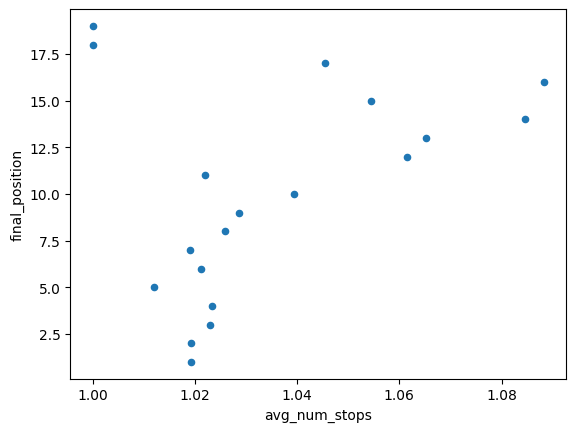

In [ ]:
num_stop_influence = pd.read_sql_query(
    """
    SELECT
        AVG(pit_stop) as avg_num_stops,
        final_position
    FROM 
        formula_one
    GROUP BY
        final_position
    ORDER BY
        avg_num_stops
    """, conn)
display(num_stop_influence)
num_stop_influence.plot(kind='scatter', x='avg_num_stops', y='final_position')

# Calculate correlation
correlation = num_stop_influence['avg_num_stops'].corr(num_stop_influence['final_position'])
print("Pearson correlation coefficient:", correlation)


### Are there circuits where certain drivers consistently perform well?

### How does the constructor (team) influence driver performance?

### Which drivers have better overall performance

### How does the average lap times influence the driver’s final position?

### Which drivers have the most consistent lap times per race

### How does the average pit stop duration influence the driver’s final position?

,avg_stop_duration,avg_final_position
0,24.167799,3.013423
1,23.838047,3.086207
2,23.979541,3.889503
3,23.299958,3.958333
4,23.461391,4.282609
...,...,...
63,26.376000,16.000000
64,26.237000,16.000000
65,24.863000,16.000000
66,27.681000,17.000000


Pearson correlation coefficient: 0.2018891225922038


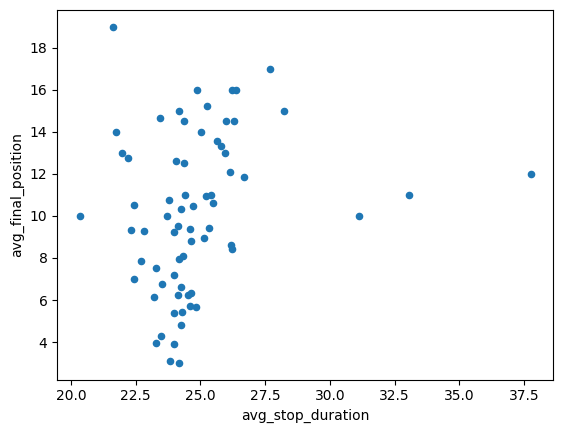

In [218]:
stop_duration_influence = pd.read_sql_query(
    """
    SELECT
        AVG(stop_duration) AS avg_stop_duration,
        AVG(final_position) as avg_final_position
    FROM 
        formula_one
    GROUP BY
        driverId
    ORDER BY
        avg_final_position
    """, conn)
display(stop_duration_influence)
stop_duration_influence.plot(kind='scatter', x='avg_stop_duration', y='avg_final_position')

# Calculate correlation
correlation = stop_duration_influence['avg_stop_duration'].corr(stop_duration_influence['avg_final_position'])
print("Pearson correlation coefficient:", correlation)


### What are the strongest correlations between features and final race position?

### Find skewness and outliers

In [219]:
conn.commit()
conn.close()

In [220]:
df.skew(numeric_only=True)

resultId                -0.019320
raceId                   0.013472
driverId                -0.421294
constructorId            0.983875
final_position           0.555701
milliseconds             3.856981
statusId                 0.000000
year                     0.003373
circuitId                1.129434
driver_points            1.601262
lap_time_milliseconds    1.512223
pit_stop                 7.348188
stop_duration            1.583986
qualifying_position      0.559215
dtype: float64